## Import library

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
import random
import tensorflow as tf

## Import dataset

In [13]:
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

## Scale data

In [14]:
scaler=MinMaxScaler(feature_range=(0,1))

## Standardize data

In [15]:
def standardizate_data(train, test, pre_test, f30, f60, f90):
  train = np.reshape(train, (-1,1))
  train1 = scaler.inverse_transform(train)

  test = np.reshape(test, (-1,1))
  test1 = scaler.inverse_transform(test)

  pre_test = np.reshape(pre_test, (-1,1))
  pre_test1 = scaler.inverse_transform(pre_test)

  f30 = np.reshape(f30, (-1,1))
  f30_1 = scaler.inverse_transform(f30)
   
  f60 = np.reshape(f60, (-1,1))
  f60_1 = scaler.inverse_transform(f60)
  
  f90 = np.reshape(f90, (-1,1))
  f90_1 = scaler.inverse_transform(f90)
    
  return train1, test1, pre_test1, f30_1, f60_1, f90_1

## Evaluate model

In [16]:
def evaluate (forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

## Convert data

In [17]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def convert_data(train, test, time_step):
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)

    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

## Forecast function

In [18]:
def forecast_days(model, test, time_step):
  x_input = test[len(test)-time_step:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  f30=[]
  f60=[]
  f90=[]
  n_steps=time_step
  i=0
  while(i<90):
      if(len(temp_input)>time_step):
          x_input=np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1)) #3D
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          if i < 30:
            f30.extend(yhat.tolist())
          elif i < 60:
            f60.extend(yhat.tolist())
          else:
            f90.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          print(len(temp_input))
          f30.extend(yhat.tolist())
          i=i+1
  return f30, f60, f90

## Visualize model

In [19]:
def visualize_GRU(train, test, pre_test, f30, f60, f90, time_step, ratio, currency):
    start_date = pd.to_datetime('3/1/2019')
    end_date = pd.to_datetime('6/1/2024')
    start_date_fc = pd.to_datetime('6/2/2024')
    
    index = pd.date_range(start=start_date, end=end_date, freq='d')
    forecast_index = pd.date_range(start=start_date_fc, periods=90, freq='d')
    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    pre_test_index = index[len(train) + (time_step) : len(train) + len(test)]

    f30_index = forecast_index[:30]
    f60_index = forecast_index[30:60]
    f90_index = forecast_index[60:]
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.xticks(x_ticks, unique_years)    
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    plt.plot(f30_index, scaler.inverse_transform(f30))
    plt.plot(f60_index, scaler.inverse_transform(f60))
    plt.plot(f90_index, scaler.inverse_transform(f90))
    plt.title(f'GRU model - {currency} ({int(ratio*10)}:{(10 - int(ratio*10))})')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','PredictedTest','ForecastNext30Days','ForecastNext60Days','ForecastNext90Days'])
    plt.show()

## Implement model

In [20]:
def implementGRU(train, test, ratio, currency):
  # set seed
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)
  
  time_step = 40
  X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

  # Define GRU Model
  model = Sequential()
  model.add(GRU(50, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit model
  model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
  
  # Predict test data
  pre_test = model.predict(X_test)
  
  # Forecase data next 30,60,90 days
  f30, f60, f90 = forecast_days(model, test, time_step)
  
  # Visualize model
  visualize_GRU(train, test, pre_test, f30, f60, f90, time_step, ratio, currency)

  # Standardize data
  train, test, pre_test, f30, f60, f90 = standardizate_data(train, test, pre_test, f30, f60, f90)
  
  # Evaluate model
  test1 = test[time_step:]
  evaluate(pre_test, test1)

# EUR_VND

In [21]:
currency = "EUR_VND"

eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
# case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
# case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

* Case 7:3

Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.2306 - val_loss: 0.0212
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0199 - val_loss: 0.0048
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032 - val_loss: 9.5150e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - val_loss: 6.8437e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 5.4984e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.4642e-04 - val_loss: 5.0414e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.6570e-04 - val_loss: 4.9758e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.9557e-04 - val_loss: 4.9663e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.6527e-04 - val_loss: 4.8938e-04
Epoch 12/100
21/21 ━

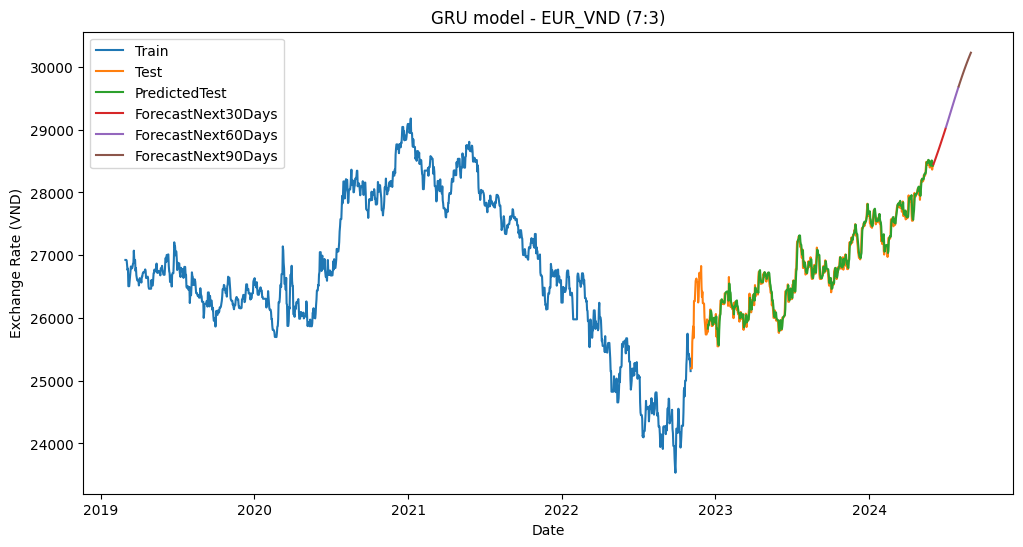

RMSE = 95.49231771550136
MAPE = 0.25906752182346043
MAE = 69.4475826434237


In [22]:
ratio = 0.7
implementGRU(train_eur_1_sc, test_eur_1_sc, ratio, currency)

* Case 8:2

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.2085 - val_loss: 0.0144
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0141 - val_loss: 0.0049
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0038 - val_loss: 9.7775e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0025 - val_loss: 7.3349e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015 - val_loss: 5.4876e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.9173e-04 - val_loss: 4.6021e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.7390e-04 - val_loss: 4.2995e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.0206e-04 - val_loss: 4.1870e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.7398e-04 - val_loss: 4.0901e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.5405e-04 - val_loss: 3.9837e-04

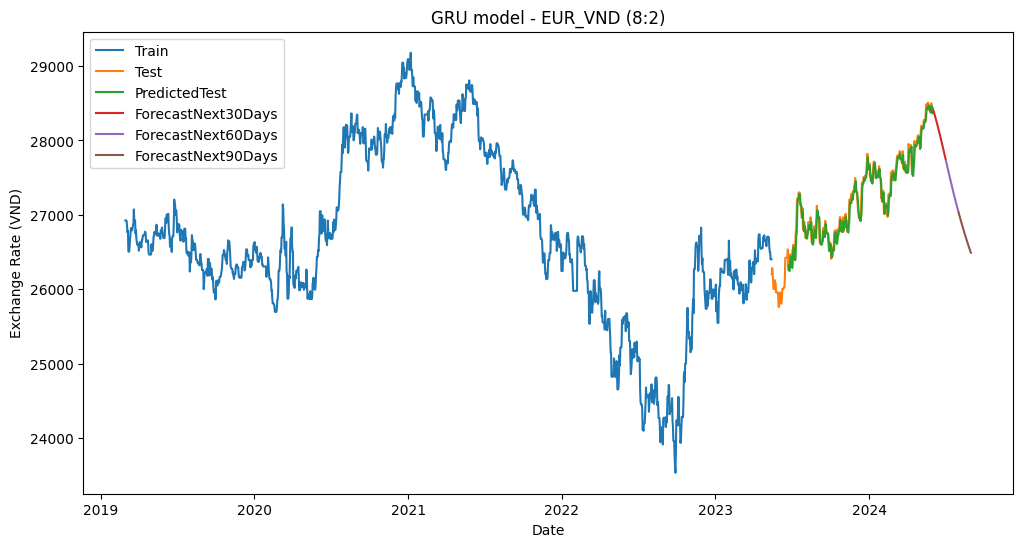

RMSE = 93.50021615612428
MAPE = 0.2531810605535442
MAE = 68.95514625726754


In [23]:
ratio = 0.8
implementGRU(train_eur_2_sc, test_eur_2_sc, ratio, currency)

* Case 9:1

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.1993 - val_loss: 0.0030
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0088 - val_loss: 0.0039
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012 - val_loss: 6.1281e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.4920e-04 - val_loss: 4.2107e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.9833e-04 - val_loss: 3.5267e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.4732e-04 - val_loss: 3.3101e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.2296e-04 - val_loss: 3.1996e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.0471e-04 - val_loss: 3.1130e-04
Epoch 12

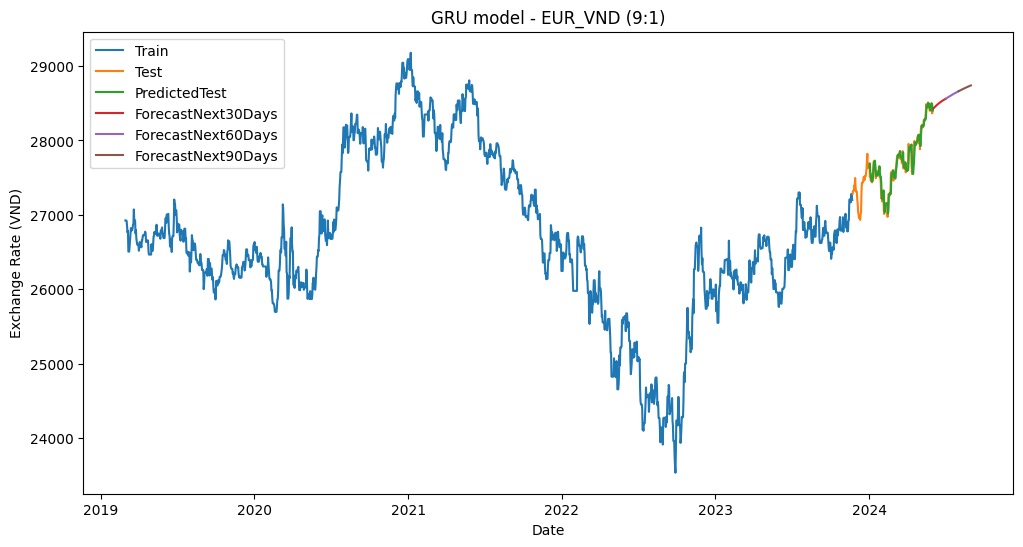

RMSE = 82.34811093924148
MAPE = 0.203872251505978
MAE = 56.430599814967294


In [24]:
ratio = 0.9
implementGRU(train_eur_3_sc, test_eur_3_sc, ratio, currency)

# JPY_VND

In [25]:
currency = "JPY_VND"
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

* Case 7:3

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.3567 - val_loss: 0.0819
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0253 - val_loss: 0.0311
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0091 - val_loss: 0.0361
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0056 - val_loss: 0.0228
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0040 - val_loss: 0.0162
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0028 - val_loss: 0.0102
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.1252e-04 - val_loss: 0.0016
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.0655e-04 - val_loss: 8.5861e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.1223e-04 - val_loss: 5.8035e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━

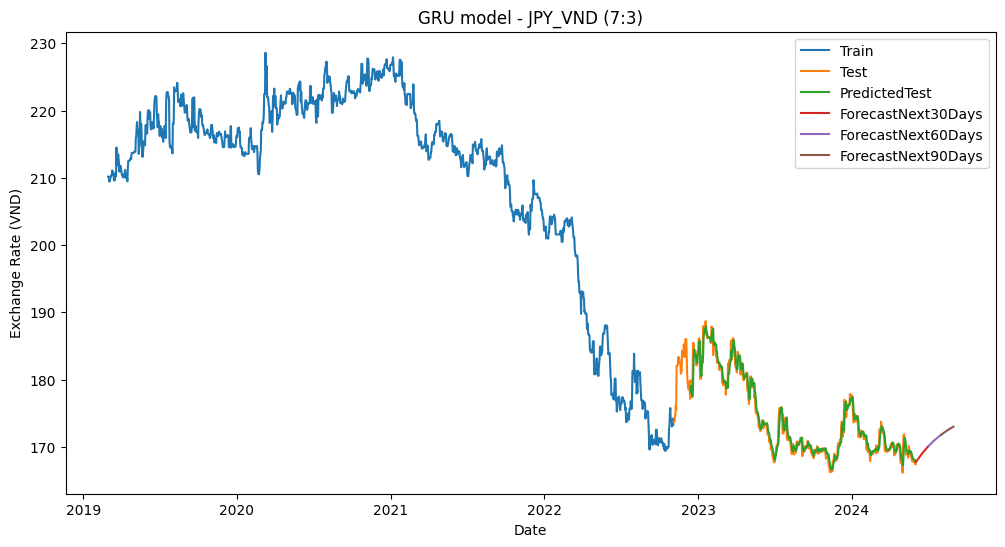

RMSE = 1.0437190630602828
MAPE = 0.40755060511090696
MAE = 0.7141633298503819


In [26]:
ratio = 0.7
implementGRU(train_jpy_1_sc, test_jpy_1_sc, ratio, currency)

* Case 8:2

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.3025 - val_loss: 0.0874
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0209 - val_loss: 0.0316
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0080 - val_loss: 0.0235
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0045 - val_loss: 0.0126
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.3093e-04 - val_loss: 7.0718e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.8846e-04 - val_loss: 4.2469e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.5814e-04 - val_loss: 3.6518e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.4573e-04 - val_loss: 3.5228e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.3389e-04 - val_loss: 3.4880e-04
Epoch 12/100

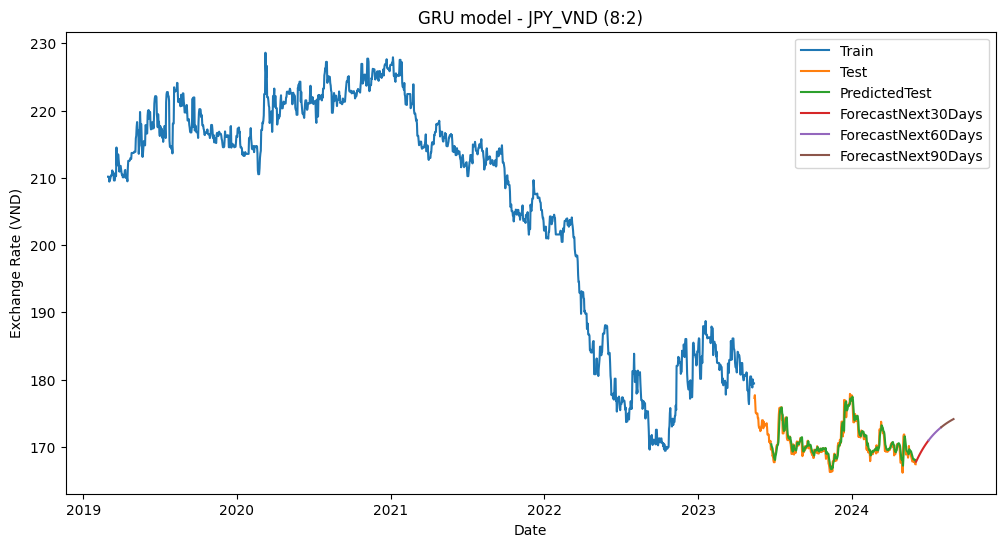

RMSE = 0.8602590860535474
MAPE = 0.35546493643492355
MAE = 0.6071803975659751


In [27]:
ratio = 0.8
implementGRU(train_jpy_2_sc, test_jpy_2_sc, ratio, currency)

* Case 9:1

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.2648 - val_loss: 0.0703
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0157 - val_loss: 0.0230
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.2092e-04 - val_loss: 4.2823e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3109e-04 - val_loss: 3.0834e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.1213e-04 - val_loss: 3.0670e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9607e-04 - val_loss: 3.0594e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8097e-04 - val_loss: 3.0001e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6753e-04 - val_loss: 2.9403e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.5550e-04 - val_loss: 2.8872e

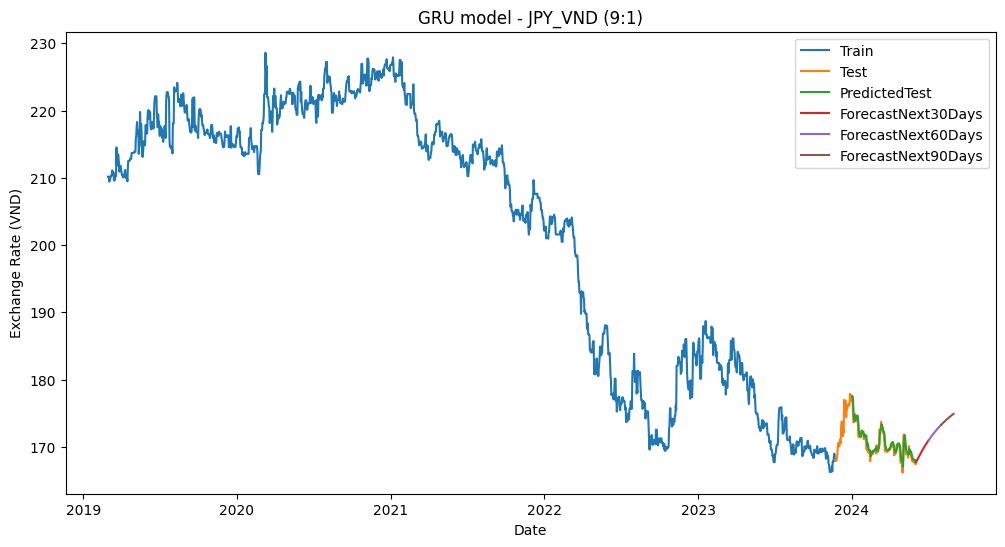

RMSE = 0.7878608708096024
MAPE = 0.3324735911201444
MAE = 0.5667169068989015


In [28]:
ratio = 0.9
implementGRU(train_jpy_3_sc, test_jpy_3_sc, ratio, currency)

# GBP_VND

In [29]:
currency = "GBP_VND"

gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

* Case 7:3

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.2509 - val_loss: 0.0201
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0200 - val_loss: 0.0080
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0065 - val_loss: 0.0029
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 9.7737e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 7.2965e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0012 - val_loss: 5.7816e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0010 - val_loss: 4.9717e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.9519e-04 - val_loss: 4.5757e-04
Epoch 12/100
21/21 ━━━━━━━━━

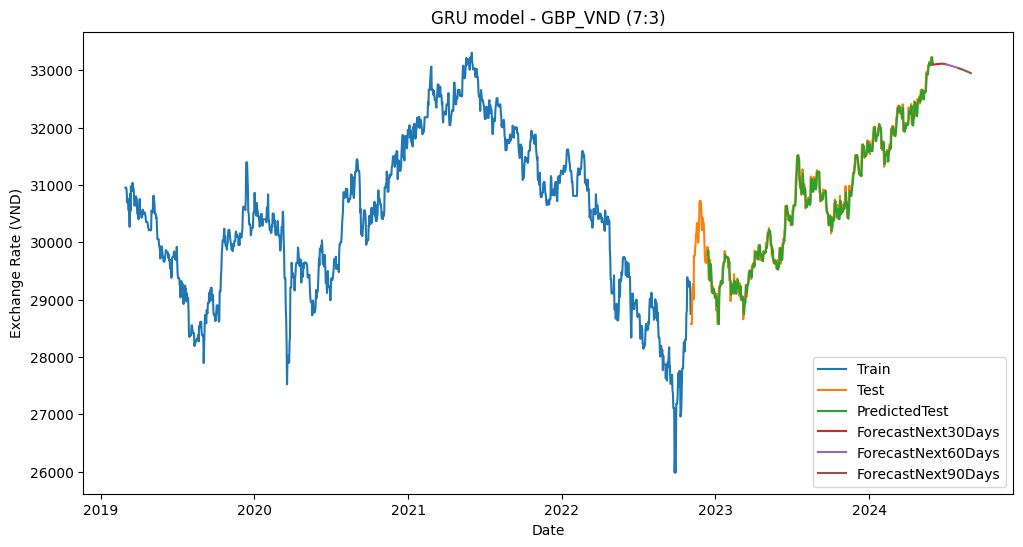

RMSE = 124.99984650033095
MAPE = 0.2857707281963348
MAE = 87.5920483034048


In [30]:
ratio = 0.7
implementGRU(train_gbp_1_sc, test_gbp_1_sc, ratio, currency)

* Case 8:2

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.2186 - val_loss: 0.0125
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0139 - val_loss: 0.0088
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0020 - val_loss: 9.9713e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014 - val_loss: 6.6368e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0011 - val_loss: 4.7837e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 8.5613e-04 - val_loss: 3.9402e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.6286e-04 - val_loss: 3.6584e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.2098e-04 - val_loss: 3.5888e-04
Epoch 12/100
24

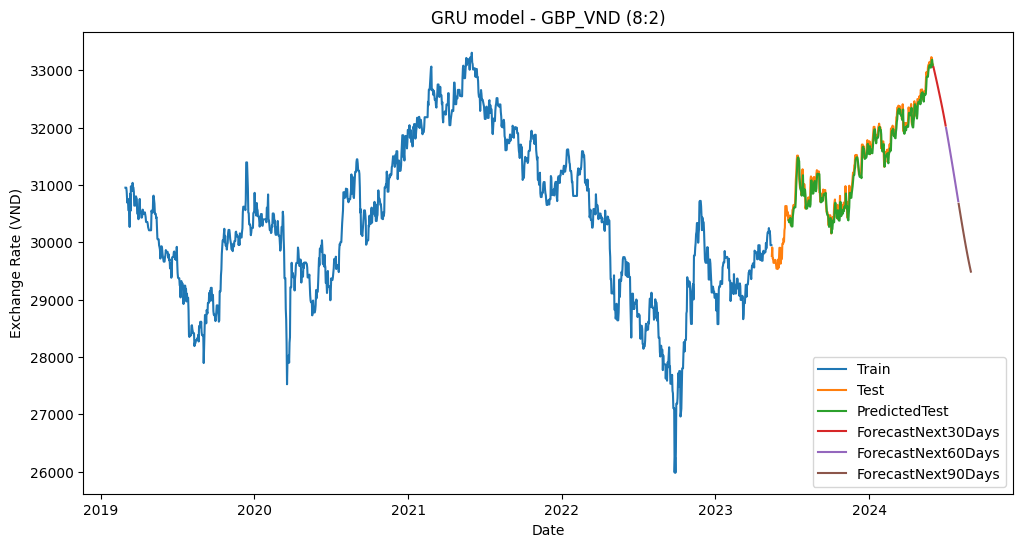

RMSE = 128.48903756658672
MAPE = 0.3153380695287611
MAE = 99.09909838299421


In [31]:
ratio = 0.8
implementGRU(train_gbp_2_sc, test_gbp_2_sc, ratio, currency)

* Case 9:1

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.2196 - val_loss: 0.0017
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0044 - val_loss: 0.0075
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.8975e-04 - val_loss: 6.9712e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.2183e-04 - val_loss: 4.2552e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.4291e-04 - val_loss: 3.2827e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.0533e-04 - val_loss: 2.9487e-04
Epoch 12/100
27/27 ━

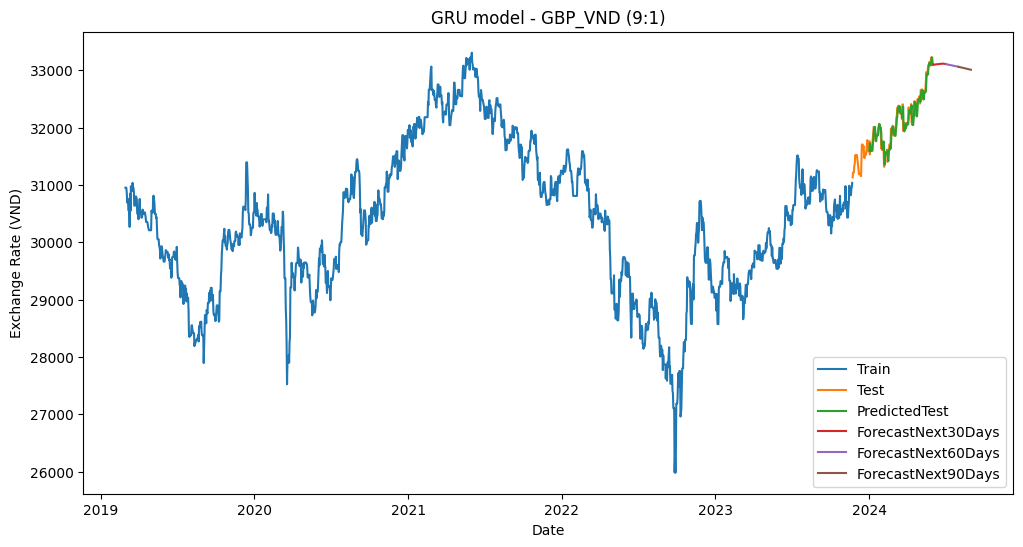

RMSE = 106.64320120622861
MAPE = 0.23247737391059506
MAE = 74.63042249177649


In [32]:
ratio = 0.9
implementGRU(train_gbp_3_sc, test_gbp_3_sc, ratio, currency)